In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from mps import a_mps as mps
from mps import b_model as model
from mps import d_dmrg as dmrg
from mps import tfi_exact
import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
L = 14
J = 1
g = 1.5
psi = mps.init_spinup_MPS(L)
m = model.TFIModel(L, J, g)
engine = dmrg.DMRGEngine(psi, m)

assert engine.psi is psi
print(f"{m.energy(psi) = }")

i = 0
while not engine.converged():
    engine.sweep()
    i += 1

print(f"{i = }")

print(f"{m.energy(psi) = }")
print(f"{tfi_exact.finite_gs_energy(L, J, g) = }")


m.energy(psi) = -21.0
i = 3
m.energy(psi) = -23.222959434117364
tfi_exact.finite_gs_energy(L, J, g) = -23.222959434117378


In [3]:
def get_ground_state(L: int, J: float, g: float) -> tuple[mps.MPS, model.TFIModel]:
    psi = mps.init_spinup_MPS(L)
    m = model.TFIModel(L, J, g)
    engine = dmrg.DMRGEngine(psi, m)

    while not engine.converged():
        engine.sweep()

    return psi, m

In [10]:
Ls = [8, 16, 32, 64,96, 128]
gs = [1.5, 1.0, 0.5]
Js = [1.0]

# (L, J, g) -> entanglement entropy
S: dict[tuple[int, float, float]] = {}

for g in gs:
    for J in Js:
        for L in tqdm.tqdm(Ls):
            psi, m = get_ground_state(L, J, g)
            S[(L, J, g)] = psi.entanglement_entropy()[L//2]

100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


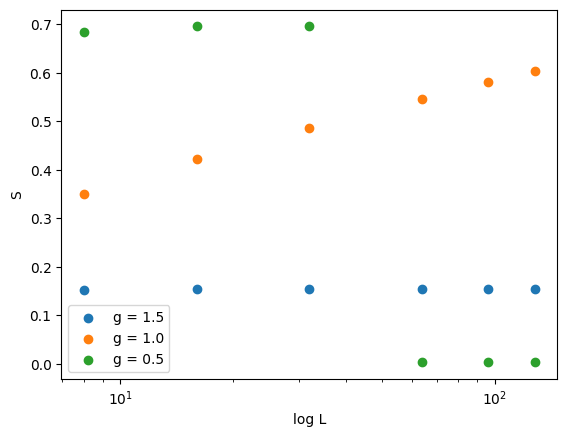

In [12]:
plt.figure()
for i, g in enumerate(gs):
    for J in Js:
        plt.scatter(Ls, [S[L, J, g] for L in Ls], label=f"{g = }")
plt.xscale("log")
plt.xlabel("log L")
plt.ylabel("S")
plt.legend()
plt.show()

In [20]:
ignore_n_first = 2
c = np.polyfit(
    np.log(Ls[ignore_n_first:]), 
    [S[(L, 1, 1)] for L in Ls[ignore_n_first:]], 
    deg=1
    )[0] * 6
print(f"{c = }")

0.5172892625781981

In [23]:
def operator_correlation(psi: mps.MPS, X: np.ndarray, Y: np.ndarray, i: int) -> list[float]:
    out = []
    # j = i
    out.append(psi.site_expectation_value(X @ Y)[i])

    left = psi.Ss[i]**2 # vC
    left = np.tensordot(np.diag(left), psi.Bs[i], axes=[0, 0]) # [vC] vC*, [vC] i vR
    left = np.tensordot(left, X, axes=[1, 0]) # vC* [i] vR, [i] i*
    left = np.tensordot(left, psi.Bs[i].conj(), axes=[[0, 2], [0, 1]]) # [vC*] vR [i*], [vC*] [i*] vR*
    # j > i
    for j in range(i + 1, psi.L):
        Bj = psi.Bs[j]
        right = np.tensordot(Bj, Y, axes=[1, 0]) # vL [i] vR, [i] i*
        right = np.tensordot(right, Bj.conj(), axes=[[1, 2], [2, 1]]) # vL [vR] [i*], vL* [i*] [vR*]
        res = np.tensordot(left, right, axes=[[0, 1], [0, 1]]) # vR vR*, vL vL*
        out.append(res)
        left = np.tensordot(left, Bj, axes=[0, 0]) # [vR] vR*, [vL] i vR
        left = np.tensordot(left, Bj.conj(), axes=[[0, 1], [0, 1]]) # [vR*] [i] vR, [vL*] [i*] vR*
    return out

100%|██████████| 5/5 [02:07<00:00, 25.55s/it]


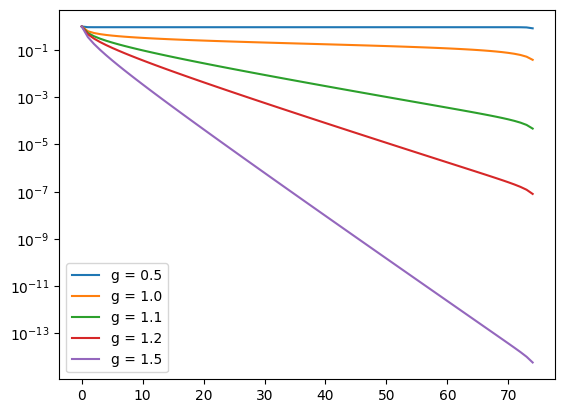

In [24]:
L = 100
plt.figure()
for g in tqdm.tqdm([0.5, 1.0, 1.1, 1.2, 1.5]):
    psi, m = get_ground_state(L, 1, g)
    plt.plot(operator_correlation(psi, m.sigmax, m.sigmax, L // 4), label=f"{g = }")
plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
L = 100
plt.figure()
for g in tqdm.tqdm([0.5, 1.0, 1.1, 1.2, 1.5]):
    psi, m = get_ground_state(L, 1, g)
    plt.plot(operator_correlation(psi, m.sigmax, m.sigmax, L // 4), label=f"{g = }")
plt.yscale("log")
plt.legend()
plt.show()

This is testing the pre-commit script